## Task 1

In [1]:
from keras import datasets
import numpy as np
#from keras.models import Sequential
#from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from numpy.random import default_rng as rng
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

## Load Dataset

In [2]:
def load_dataset():

    data = datasets.mnist.load_data()

    (X_train, y_train), (X_test, y_test) = data

    
    
    X_train = X_train / 255
    X_test = X_test / 255
    
    

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    X_train = np.reshape(X_train, [X_train.shape[0], 28 * 28])
    X_test = np.reshape(X_test, [X_test.shape[0], 28 * 28])

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    print(X_train[0])
    print(y_test)

    print(y_train.shape)
    
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = load_dataset()

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.41807799e-03 -5.75481961e-03 -4.08251693e-03 -4.08251693e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.08251693e-03 -4.70968827e-03 -8.79934640e-03 -1.15905591e-02
 -1.47589798e-02 -1.92848546e-02 -2.46717975e-02 -2.90710271e-02
 -3.05926583e-02 -3.11640127e-02 -3.19628719e-02 -3.02025355e-02
 -3.13102175e-02 -2.83833960e-02 -2.31191906e-02 -1.91666260e-02
 -1.67723008e-02 -1.09963601e-02 -8.32486080e-03 -4.38069356e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.08251693e-03 -5.39534598e-03
 -8.52241235e-03 -1.19850

## Relu Layer

In [4]:
class Activation_Layer_ReLU:
    
    def forward_pass(self, x):
        
        self.x = x
        
        return np.maximum(0, x)
    
    def backward_pass(self, dvalues):
        
        #return (x > 0) * 1
        
        return (np.greater(self.x, 0).astype(int)) * dvalues
        

## Sigmoid Layer

In [5]:
class Activation_Layer_Sigmoid:
    
    def forward_pass(self, x):
        
        self.sigmoid = 1 / (1 + np.exp(-x))
        
        return self.sigmoid
    
    def backward_pass(self, dvalues):
        
        return (self.sigmoid * (1 - self.sigmoid)) * dvalues


## Softmax Layer

In [6]:
class Activation_Layer_Softmax:
    
    def forward_pass(self, x):
        
        exponents = np.exp(x - np.max(x, axis = 1, keepdims = True))
        
        self.softmax_out = exponents / np.sum(exponents, axis = 1, keepdims = True)
        
        return self.softmax_out
    
    def backward_pass(self, dvalues):
        
        self.dinputs = np.empty_like(dvalues) # Create empty array same size as input gradients
        
        for idx, (single_output, single_dvalue) in enumerate(zip(self.softmax_out, dvalues)):
            
            single_output = single_output.reshape(-1, 1) # Flatten output
            
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T) # Create a jacobian matrix for each output 
            
            self.dinputs[idx] = np.dot(jacobian_matrix, single_dvalue) # Calculate sample-wise gradients
        
        return self.dinputs * dvalues


## Dense Layer

In [94]:
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons):
        
        self.weights = (np.random.randn(n_inputs, n_neurons) * np.sqrt(2/n_neurons)) #He Initialisation
        self.biases = 0.01 * (np.random.randn(1, n_neurons))

    def forward_pass(self, x):
        
        self.x = x
        
        return np.dot(x, self.weights) + self.biases
    
    def backward_pass(self, dvalues):
        
        N = len(self.x)
        
        self.dweights = np.dot(self.x.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs = (1/N) * np.dot(dvalues, self.weights.T)
        
        return self.dinputs

## Dropout Layer

In [95]:
class Layer_Dropout:
    
    def __init__(self, drop_prob):
        
        self.drop_prob = 1 - drop_prob
        
    def forward_pass(self, x):
        
        self.x = x
        
        self.mask = (np.random.rand(*self.x.shape) < self.drop_prob) / self.drop_prob
        
        return self.x * self.mask
        
    def backward_pass(self, dvalues):
        
        self.dinputs = dvalues * self.mask
        
        return self.dinputs
    

## Categorical Cross Entropy Loss

In [96]:
class Loss_Cross_Entropy(Loss):
    
    def forward_pass(self, y_pred, y_true):
        
        N = len(y_pred)
        
        y_pred_clipped = np.clip(y_pred, 1e-10, 1 - 1e-10)
        
        """neg_log_likelihood = np.mean((-1/N) * np.sum(np.dot(y_true.T, np.log(y_pred_clipped))
                                             + np.dot((1 - y_true).T, np.log(1 - y_pred_clipped)), axis = 1))"""
        
        #neg_log_likelihood = np.mean((-1/N) * np.sum(np.dot(y_true.T, np.log(y_pred_clipped)), axis = 1))
        
        #neg_log_likelihood = np.mean((-1) * np.sum(np.dot(y_true.T, np.log(y_pred_clipped))))
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        # Losses
        neg_log_likelihood = np.mean(-np.log(correct_confidences))
        
        return neg_log_likelihood
        

## Cross Entropy Loss + Softmax Activation Layer

In [97]:
class Activation_Softmax_Layer_Loss_Cross_Entropy:
    
    def __init__(self):
        self.activation = Activation_Layer_Softmax()
        self.loss = Loss_Cross_Entropy()
        
    def forward_pass(self, x, y_true):
        
        self.x = x
        
        self.softmax_output = self.activation.forward_pass(x)
        self.mean_loss = self.loss.calculate_mean_loss(self.softmax_output, y_true)
        
        return self.softmax_output
        
    def backward_pass(self, y_pred, y_true):
        
        N = len(y_pred)
        
        #self.dinputs = (1/N) * ((self.softmax_output) * self.activation.backward_pass(dvalues))

        #self.dinputs = np.mean((1/N) * np.sum(np.dot(self.x.T, y_pred - y_true), axis = 1))
        
        #self.dinputs = (1/N) * np.sum(np.dot((y_pred - y_true), self.x.T), axis = 1)
        
        #self.dinputs = y_pred - y_true
        
        #self.dinputs = np.mean((1/N) * np.sum(np.dot(self.x.T, y_pred - y_true), axis = 1))
        
        #print(((y_pred - y_true) * self.x).shape)
        
        if len(y_true.shape) == 2:
            
            y_true = np.argmax(y_true, axis = 1)
            
        self.dinputs = y_pred.copy()
        
        self.dinputs[range(N), y_true] -= 1
        
        self.dinputs = (1/N) * self.dinputs

        
        return self.dinputs
    

## Stochastic Gradient Descent Optimiser

In [98]:
class Optimiser_SGD:
    
    def __init__(self, learning_rate = 0.5, decay = 0, momentum = 0):
        
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    def update_learning_rate(self): #Learning rate decay
        
        if self.decay:
            
            self.current_learning_rate = self.learning_rate * (1/(1 + self.decay * self.iterations))
    
    def update_iterations(self):
        
        self.iterations += 1
    
    def update_values(self, layer):
        
        if self.momentum:
            
            if not hasattr(layer, "weight_momentum"):
                
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.bias_momentum = np.zeros_like(layer.biases)
                
            new_weights = (self.momentum * layer.weight_momentum) - (self.current_learning_rate * layer.dweights)
            layer.weight_momentum = new_weights
            
            new_biases = (self.momentum * layer.bias_momentum) - (self.current_learning_rate * layer.dbiases)
            layer.bias_momentum = new_biases
            
        else:
            
            new_weights -= self.learning_rate * layer.dweights
            new_biases -= self.learning_rate * layer.dbiases
        
        layer.weights += new_weights
        layer.biases += new_biases
        

## Mini Batch Gradient Descent Optimiser

In [99]:
class Optimiser_Mini_Batch_GD:
    
    def __init__(self, learning_rate = 0.5, batch_size = 32):
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        
    def generate_batches(self, X, y):
        
        mini_batches = []
        
        X, y = shuffle(X, y)
        
        for idx in range(0, X.shape[0], self.batch_size):
            
            X_batch = X[idx:idx + self.batch_size]
            y_batch = y[idx:idx + self.batch_size].reshape(-1, 1)
        
        mini_batches.append((X_batch, y_batch))
        
        return mini_batches
    
    def mini_batch_gradient_descent(self, X, y, layer):
        
        mini_batches = self.generate_batches(X, y)
        
        for batch in mini_batches:
            
            x_batch, y_batch = batch
            
            layer.weights -= self.learning_rate * layer.dweights
            layer.biases -= self.learning_rate * layer.dbiases
            

## Neural Network Class

In [108]:
class NeuralNetwork:
    
    def __init__(self, learning_rate, batch_size, epochs, input_layer_size, output_layer_size, neuron_size):
        
        self.layers = []
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_layer_size = input_layer_size
        self.output_layer_size = output_layer_size
        self.neuron_size = neuron_size
        
        self.loss_history = []
        self.accuracy_history = []
    
    def fit(self, X_train, y_train):
        
        batches = self.generate_batches(X_train, y_train, self.batch_size)
        
        self.num_batches = len(batches)
        
        print(len(batches))
        
        #self.generate_layers()
        
        self.loss_activation = Activation_Softmax_Layer_Loss_Cross_Entropy()

        self.optimiser = Optimiser_SGD(learning_rate = self.learning_rate, decay = 0.001, momentum = 0.9)
        
        idx = 0
        
        for batch in batches:
            
            idx += 1
            
            print("Batch", idx, "of", self.num_batches)
            
            X_train, y_train = batch

            for epoch in range(self.epochs):

                layer_output = self.layers[0].forward_pass(X_train)
                
                for layer in self.layers[1:]:
                    
                    layer_output = layer.forward_pass(layer_output)
                
                forward_pass_output = self.loss_activation.forward_pass(layer_output, y_train)

                loss = self.loss_activation.mean_loss

                y_pred = np.argmax(forward_pass_output, axis = 1)
                y_valid = np.argmax(y_train, axis = 1)
                
                accuracy = accuracy_score(y_valid, y_pred)

                self.loss_history.append(loss)
                self.accuracy_history.append(accuracy)

                if epoch % 10 == 0:

                    print("epoch:", epoch, "\tloss:", loss, "\tacc:", accuracy)#, "lr:", optimiser.current_learning_rate)


                #Backward Pass
                
                layer_gradient = self.loss_activation.backward_pass(layer_output, y_train)
                
                #for layer in self.layers[:len(self.layers) - 1:-1]:
                for layer in reversed(self.layers[:len(self.layers) - 1]):
                    
                    layer_gradient = layer.backward_pass(layer_gradient)

                self.optimise("SGD")               

            print("epoch:", epoch, "\tloss:", loss, "\tacc:", accuracy, "\n")
        
    def predict(self, X_test):
        
        layer_output = self.layers[0].forward_pass(X_train)
                
        for layer in self.layers[1:]:
            
            # Skip dropout during testing
            if isinstance(layer, Layer_Dropout):
                
                continue
                
            layer_output = layer.forward_pass(layer_output)
                
        forward_pass_output = self.loss_activation.forward_pass(layer_output, y_train)

        loss = self.loss_activation.mean_loss

        y_pred = np.argmax(forward_pass_output, axis = 1)
        y_valid = np.argmax(y_train, axis = 1)

        accuracy = accuracy_score(y_valid, y_pred)
        
        print("loss:", loss, "acc:", accuracy)
    
    def add(self, layer):
        
        self.layers.append(layer)
        
    def optimise(self, optimiser_type):
        
        if optimiser_type == "SGD":
            
            self.optimiser.update_learning_rate() # For learning rate decay
            
            for layer in self.layers:
                
                if isinstance(layer, Layer_Dense):
                    
                    self.optimiser.update_values(layer)
                    
            self.optimiser.update_iterations()
                    
    
    def generate_batches(self, X, y, batch_size):
        
        mini_batches = []
        
        X, y = shuffle(X, y)
        
        for idx in range(0, X.shape[0], batch_size):
            
            X_batch = X[idx:idx + batch_size]
            y_batch = y[idx:idx + batch_size]
        
            mini_batches.append((X_batch, y_batch))
        
        return mini_batches
        

In [125]:
learning_rate = 0.3
batch_size = 100
epochs = 50
input_layer_size = X_train.shape[1]
neuron_size = 250
output_layer_size = 10

network = NeuralNetwork(learning_rate = learning_rate, batch_size = batch_size, epochs = epochs, 
                        input_layer_size = input_layer_size, neuron_size = neuron_size, 
                        output_layer_size = output_layer_size)

In [126]:
network.add(Layer_Dense(X_train.shape[1], neuron_size))
network.add(Activation_Layer_ReLU())

network.add(Layer_Dropout(0.1))

network.add(Layer_Dense(neuron_size, neuron_size))
network.add(Activation_Layer_ReLU())

#network.add(Activation_Layer_Sigmoid())

network.add(Layer_Dense(neuron_size, output_layer_size))
network.add(Activation_Layer_Softmax())

In [127]:
network.fit(X_train, y_train)

600
Batch 1 of 600
epoch: 0 	loss: 2.3178561305597554 	acc: 0.14
epoch: 10 	loss: 1.619537924648342 	acc: 0.86
epoch: 20 	loss: 1.4888339633946972 	acc: 0.98
epoch: 30 	loss: 1.464365579659847 	acc: 1.0
epoch: 40 	loss: 1.4625363318550584 	acc: 1.0
epoch: 49 	loss: 1.4635046804562573 	acc: 1.0 

Batch 2 of 600
epoch: 0 	loss: 1.844448568570221 	acc: 0.61
epoch: 10 	loss: 1.6010289352203395 	acc: 0.87
epoch: 20 	loss: 1.4981829876330246 	acc: 0.97
epoch: 30 	loss: 1.4725480452418216 	acc: 0.99
epoch: 40 	loss: 1.4740303327755067 	acc: 0.99
epoch: 49 	loss: 1.4617120701420427 	acc: 1.0 

Batch 3 of 600
epoch: 0 	loss: 1.7980218917633337 	acc: 0.66
epoch: 10 	loss: 1.5644362039366637 	acc: 0.92
epoch: 20 	loss: 1.4823198354396865 	acc: 1.0
epoch: 30 	loss: 1.4679958515676697 	acc: 1.0
epoch: 40 	loss: 1.4620813053943322 	acc: 1.0
epoch: 49 	loss: 1.462878475014325 	acc: 1.0 

Batch 4 of 600
epoch: 0 	loss: 1.839303021165293 	acc: 0.6
epoch: 10 	loss: 1.611864994038356 	acc: 0.89
epoch: 20

epoch: 49 	loss: 1.4718283641880379 	acc: 0.99 

Batch 29 of 600
epoch: 0 	loss: 1.7364524985413643 	acc: 0.72
epoch: 10 	loss: 1.6598634624445612 	acc: 0.83
epoch: 20 	loss: 1.6009089314502 	acc: 0.89
epoch: 30 	loss: 1.561037008870056 	acc: 0.92
epoch: 40 	loss: 1.5221130803786211 	acc: 0.97
epoch: 49 	loss: 1.5247820039801823 	acc: 0.98 

Batch 30 of 600
epoch: 0 	loss: 1.689702371747938 	acc: 0.79
epoch: 10 	loss: 1.5898951074020715 	acc: 0.88
epoch: 20 	loss: 1.5085174711936278 	acc: 0.97
epoch: 30 	loss: 1.5011469934481858 	acc: 0.98
epoch: 40 	loss: 1.4944340046996734 	acc: 0.99
epoch: 49 	loss: 1.480867060877234 	acc: 0.99 

Batch 31 of 600
epoch: 0 	loss: 1.7691087946179676 	acc: 0.7
epoch: 10 	loss: 1.6458977944430204 	acc: 0.83
epoch: 20 	loss: 1.5877069112085942 	acc: 0.9
epoch: 30 	loss: 1.502795947962842 	acc: 0.98
epoch: 40 	loss: 1.5062934974943871 	acc: 0.98
epoch: 49 	loss: 1.495970941375286 	acc: 0.98 

Batch 32 of 600
epoch: 0 	loss: 1.652081533500647 	acc: 0.82
epo

epoch: 49 	loss: 1.5089092526698524 	acc: 0.98 

Batch 57 of 600
epoch: 0 	loss: 1.6842532475710363 	acc: 0.76
epoch: 10 	loss: 1.6396170389266296 	acc: 0.82
epoch: 20 	loss: 1.5336071693540867 	acc: 0.93
epoch: 30 	loss: 1.5165487983605337 	acc: 0.97
epoch: 40 	loss: 1.481936550776865 	acc: 0.99
epoch: 49 	loss: 1.498635251640581 	acc: 0.98 

Batch 58 of 600
epoch: 0 	loss: 1.7245181177757452 	acc: 0.76
epoch: 10 	loss: 1.6289804118003213 	acc: 0.86
epoch: 20 	loss: 1.5566188011527828 	acc: 0.95
epoch: 30 	loss: 1.5117837493266213 	acc: 0.96
epoch: 40 	loss: 1.4883568534326401 	acc: 0.99
epoch: 49 	loss: 1.4924954986694265 	acc: 0.99 

Batch 59 of 600
epoch: 0 	loss: 1.7107953673447653 	acc: 0.76
epoch: 10 	loss: 1.6279875244105113 	acc: 0.87
epoch: 20 	loss: 1.5933519446644424 	acc: 0.9
epoch: 30 	loss: 1.5068577834531254 	acc: 0.99
epoch: 40 	loss: 1.4987341935036032 	acc: 0.99
epoch: 49 	loss: 1.494274591262512 	acc: 0.99 

Batch 60 of 600
epoch: 0 	loss: 1.6858502166454712 	acc: 0

epoch: 49 	loss: 1.475882198245539 	acc: 1.0 

Batch 85 of 600
epoch: 0 	loss: 1.5588805764071403 	acc: 0.91
epoch: 10 	loss: 1.5111558767399302 	acc: 0.96
epoch: 20 	loss: 1.4963939405068976 	acc: 0.98
epoch: 30 	loss: 1.4973117860877487 	acc: 0.96
epoch: 40 	loss: 1.479676269100601 	acc: 0.99
epoch: 49 	loss: 1.4884231148845148 	acc: 1.0 

Batch 86 of 600
epoch: 0 	loss: 1.583944656897454 	acc: 0.87
epoch: 10 	loss: 1.518427259961485 	acc: 0.95
epoch: 20 	loss: 1.4914461448718614 	acc: 0.99
epoch: 30 	loss: 1.493819956927185 	acc: 0.98
epoch: 40 	loss: 1.466885551106088 	acc: 1.0
epoch: 49 	loss: 1.4707989693889434 	acc: 1.0 

Batch 87 of 600
epoch: 0 	loss: 1.5866776879600177 	acc: 0.89
epoch: 10 	loss: 1.5457584299667084 	acc: 0.92
epoch: 20 	loss: 1.5027999689667704 	acc: 0.97
epoch: 30 	loss: 1.488862703184108 	acc: 0.98
epoch: 40 	loss: 1.48630585883286 	acc: 0.99
epoch: 49 	loss: 1.4720813202371639 	acc: 1.0 

Batch 88 of 600
epoch: 0 	loss: 1.623718557878799 	acc: 0.85
epoch: 

epoch: 49 	loss: 1.4934525294951444 	acc: 0.99 

Batch 113 of 600
epoch: 0 	loss: 1.6092862523469091 	acc: 0.85
epoch: 10 	loss: 1.5843562591942788 	acc: 0.87
epoch: 20 	loss: 1.5389208276729818 	acc: 0.92
epoch: 30 	loss: 1.517604843579935 	acc: 0.96
epoch: 40 	loss: 1.517980496111893 	acc: 0.97
epoch: 49 	loss: 1.4900505092041834 	acc: 0.98 

Batch 114 of 600
epoch: 0 	loss: 1.6111357979820478 	acc: 0.84
epoch: 10 	loss: 1.5696084623340192 	acc: 0.9
epoch: 20 	loss: 1.526996611176712 	acc: 0.96
epoch: 30 	loss: 1.5228401089462975 	acc: 0.98
epoch: 40 	loss: 1.523413876244716 	acc: 0.96
epoch: 49 	loss: 1.4910352920179204 	acc: 1.0 

Batch 115 of 600
epoch: 0 	loss: 1.61305666727751 	acc: 0.87
epoch: 10 	loss: 1.5971286445537247 	acc: 0.86
epoch: 20 	loss: 1.5221491423838953 	acc: 0.96
epoch: 30 	loss: 1.5169181115052353 	acc: 0.96
epoch: 40 	loss: 1.5013512813345975 	acc: 0.98
epoch: 49 	loss: 1.4920706859564408 	acc: 0.99 

Batch 116 of 600
epoch: 0 	loss: 1.5855917526985286 	acc: 0

epoch: 30 	loss: 1.5040193124682775 	acc: 0.97
epoch: 40 	loss: 1.5149599464395762 	acc: 0.98
epoch: 49 	loss: 1.49206763876031 	acc: 0.98 

Batch 141 of 600
epoch: 0 	loss: 1.6021440456674803 	acc: 0.88
epoch: 10 	loss: 1.5892012553341721 	acc: 0.89
epoch: 20 	loss: 1.562662596009143 	acc: 0.89
epoch: 30 	loss: 1.5313760627267137 	acc: 0.97
epoch: 40 	loss: 1.4919428822289933 	acc: 1.0
epoch: 49 	loss: 1.5016321561046184 	acc: 0.98 

Batch 142 of 600
epoch: 0 	loss: 1.5552971061209855 	acc: 0.9
epoch: 10 	loss: 1.5396812857681612 	acc: 0.93
epoch: 20 	loss: 1.5345110974610736 	acc: 0.95
epoch: 30 	loss: 1.4992958275854602 	acc: 0.98
epoch: 40 	loss: 1.483449283786608 	acc: 0.99
epoch: 49 	loss: 1.5030756070404154 	acc: 0.98 

Batch 143 of 600
epoch: 0 	loss: 1.6147385334573505 	acc: 0.86
epoch: 10 	loss: 1.5555702114569625 	acc: 0.92
epoch: 20 	loss: 1.5226278496001846 	acc: 0.96
epoch: 30 	loss: 1.4982110774370794 	acc: 0.97
epoch: 40 	loss: 1.5183871920054801 	acc: 0.97
epoch: 49 	l

epoch: 10 	loss: 1.5359154235278525 	acc: 0.92
epoch: 20 	loss: 1.5020754935813125 	acc: 0.97
epoch: 30 	loss: 1.5006545412647296 	acc: 0.99
epoch: 40 	loss: 1.492592356663916 	acc: 0.98
epoch: 49 	loss: 1.4793436416215595 	acc: 1.0 

Batch 169 of 600
epoch: 0 	loss: 1.578197375603461 	acc: 0.89
epoch: 10 	loss: 1.5498622748068285 	acc: 0.93
epoch: 20 	loss: 1.51748253362097 	acc: 0.95
epoch: 30 	loss: 1.4941340747178407 	acc: 0.98
epoch: 40 	loss: 1.4815890132282958 	acc: 0.99
epoch: 49 	loss: 1.4800390772802874 	acc: 1.0 

Batch 170 of 600
epoch: 0 	loss: 1.5900816545662924 	acc: 0.88
epoch: 10 	loss: 1.5630289731263318 	acc: 0.9
epoch: 20 	loss: 1.5646270781617204 	acc: 0.91
epoch: 30 	loss: 1.5361955895053994 	acc: 0.94
epoch: 40 	loss: 1.5233949451114603 	acc: 0.96
epoch: 49 	loss: 1.5094139821311554 	acc: 0.97 

Batch 171 of 600
epoch: 0 	loss: 1.6118097013433388 	acc: 0.89
epoch: 10 	loss: 1.6067133923419759 	acc: 0.86
epoch: 20 	loss: 1.5427829153788246 	acc: 0.94
epoch: 30 	lo

epoch: 10 	loss: 1.6088283867996243 	acc: 0.86
epoch: 20 	loss: 1.5476106492491377 	acc: 0.94
epoch: 30 	loss: 1.5483051633417748 	acc: 0.93
epoch: 40 	loss: 1.5137835455888486 	acc: 0.97
epoch: 49 	loss: 1.529981613808143 	acc: 0.95 

Batch 197 of 600
epoch: 0 	loss: 1.5922719328516974 	acc: 0.86
epoch: 10 	loss: 1.574803062574512 	acc: 0.9
epoch: 20 	loss: 1.547665393365901 	acc: 0.93
epoch: 30 	loss: 1.5297543756096783 	acc: 0.95
epoch: 40 	loss: 1.530109375847778 	acc: 0.94
epoch: 49 	loss: 1.5157071539725633 	acc: 0.95 

Batch 198 of 600
epoch: 0 	loss: 1.5849603381767678 	acc: 0.89
epoch: 10 	loss: 1.5564263297544507 	acc: 0.93
epoch: 20 	loss: 1.5549514677997387 	acc: 0.91
epoch: 30 	loss: 1.5255161587359718 	acc: 0.97
epoch: 40 	loss: 1.5085755276094148 	acc: 0.98
epoch: 49 	loss: 1.518687886938334 	acc: 0.98 

Batch 199 of 600
epoch: 0 	loss: 1.5633854389848545 	acc: 0.91
epoch: 10 	loss: 1.5392944397463202 	acc: 0.94
epoch: 20 	loss: 1.5273159600306443 	acc: 0.95
epoch: 30 	l

epoch: 10 	loss: 1.5548352914306474 	acc: 0.92
epoch: 20 	loss: 1.5218497610330177 	acc: 0.95
epoch: 30 	loss: 1.5113960757372724 	acc: 0.95
epoch: 40 	loss: 1.4927815188955318 	acc: 0.98
epoch: 49 	loss: 1.4882195224900223 	acc: 0.99 

Batch 225 of 600
epoch: 0 	loss: 1.5360095554989224 	acc: 0.93
epoch: 10 	loss: 1.5479996312734001 	acc: 0.93
epoch: 20 	loss: 1.5302225931464377 	acc: 0.93
epoch: 30 	loss: 1.5102542239103034 	acc: 0.97
epoch: 40 	loss: 1.495858203641367 	acc: 0.99
epoch: 49 	loss: 1.5138215717930095 	acc: 0.96 

Batch 226 of 600
epoch: 0 	loss: 1.5847494447705852 	acc: 0.88
epoch: 10 	loss: 1.5826709485751158 	acc: 0.89
epoch: 20 	loss: 1.5424876084686148 	acc: 0.91
epoch: 30 	loss: 1.5116770980444922 	acc: 0.96
epoch: 40 	loss: 1.5033416832152977 	acc: 0.98
epoch: 49 	loss: 1.4919212297382631 	acc: 0.98 

Batch 227 of 600
epoch: 0 	loss: 1.6163528083158147 	acc: 0.86
epoch: 10 	loss: 1.5775734206415581 	acc: 0.91
epoch: 20 	loss: 1.5570842663580728 	acc: 0.91
epoch: 

epoch: 40 	loss: 1.532594519084765 	acc: 0.96
epoch: 49 	loss: 1.5240796114083803 	acc: 0.95 

Batch 252 of 600
epoch: 0 	loss: 1.5917699056418178 	acc: 0.9
epoch: 10 	loss: 1.5531096092337788 	acc: 0.93
epoch: 20 	loss: 1.5348887299389977 	acc: 0.94
epoch: 30 	loss: 1.5025436676994344 	acc: 0.97
epoch: 40 	loss: 1.4989404205856565 	acc: 0.98
epoch: 49 	loss: 1.4853115621918604 	acc: 0.99 

Batch 253 of 600
epoch: 0 	loss: 1.561701550758076 	acc: 0.92
epoch: 10 	loss: 1.5346835093100637 	acc: 0.94
epoch: 20 	loss: 1.4933882290760265 	acc: 0.99
epoch: 30 	loss: 1.4956792339124894 	acc: 0.98
epoch: 40 	loss: 1.49356023107048 	acc: 0.98
epoch: 49 	loss: 1.4830470644317646 	acc: 1.0 

Batch 254 of 600
epoch: 0 	loss: 1.5930898043773039 	acc: 0.86
epoch: 10 	loss: 1.555694286681499 	acc: 0.92
epoch: 20 	loss: 1.5270783363046825 	acc: 0.95
epoch: 30 	loss: 1.5160978430541914 	acc: 0.99
epoch: 40 	loss: 1.5044671852739901 	acc: 0.98
epoch: 49 	loss: 1.499301454622688 	acc: 0.98 

Batch 255 of

epoch: 20 	loss: 1.5260284090500038 	acc: 0.95
epoch: 30 	loss: 1.519536962991653 	acc: 0.97
epoch: 40 	loss: 1.4972809660829431 	acc: 0.97
epoch: 49 	loss: 1.504121755811251 	acc: 0.98 

Batch 280 of 600
epoch: 0 	loss: 1.5872151605645601 	acc: 0.91
epoch: 10 	loss: 1.5956315429830576 	acc: 0.9
epoch: 20 	loss: 1.5738216290145024 	acc: 0.91
epoch: 30 	loss: 1.5298107125045153 	acc: 0.95
epoch: 40 	loss: 1.531373023236135 	acc: 0.96
epoch: 49 	loss: 1.5352088554928927 	acc: 0.94 

Batch 281 of 600
epoch: 0 	loss: 1.606728104501411 	acc: 0.88
epoch: 10 	loss: 1.5956846484418201 	acc: 0.88
epoch: 20 	loss: 1.5752609319757114 	acc: 0.9
epoch: 30 	loss: 1.5433667876416857 	acc: 0.94
epoch: 40 	loss: 1.5250128197026347 	acc: 0.94
epoch: 49 	loss: 1.532411474958159 	acc: 0.96 

Batch 282 of 600
epoch: 0 	loss: 1.6632436947135805 	acc: 0.8
epoch: 10 	loss: 1.6177081791757173 	acc: 0.86
epoch: 20 	loss: 1.5787319535689792 	acc: 0.9
epoch: 30 	loss: 1.5597563177903317 	acc: 0.93
epoch: 40 	loss

epoch: 20 	loss: 1.5517146762327636 	acc: 0.93
epoch: 30 	loss: 1.5128072923101055 	acc: 0.96
epoch: 40 	loss: 1.5071014120541943 	acc: 0.97
epoch: 49 	loss: 1.5078510464602712 	acc: 0.98 

Batch 308 of 600
epoch: 0 	loss: 1.576674231034755 	acc: 0.9
epoch: 10 	loss: 1.5557518818484428 	acc: 0.93
epoch: 20 	loss: 1.5090701682467085 	acc: 0.97
epoch: 30 	loss: 1.527870708513372 	acc: 0.95
epoch: 40 	loss: 1.5066244834062874 	acc: 0.97
epoch: 49 	loss: 1.5096662736812108 	acc: 0.97 

Batch 309 of 600
epoch: 0 	loss: 1.5451944481112878 	acc: 0.94
epoch: 10 	loss: 1.565091341485069 	acc: 0.9
epoch: 20 	loss: 1.5331868939968802 	acc: 0.95
epoch: 30 	loss: 1.5131156078518537 	acc: 0.96
epoch: 40 	loss: 1.5022442933887592 	acc: 0.99
epoch: 49 	loss: 1.503744175230337 	acc: 0.98 

Batch 310 of 600
epoch: 0 	loss: 1.5475697774550639 	acc: 0.92
epoch: 10 	loss: 1.5427152079339073 	acc: 0.95
epoch: 20 	loss: 1.5312697546322476 	acc: 0.95
epoch: 30 	loss: 1.5192846204913824 	acc: 0.97
epoch: 40 	l

epoch: 49 	loss: 1.5043940082237877 	acc: 0.98 

Batch 335 of 600
epoch: 0 	loss: 1.5759247918743169 	acc: 0.92
epoch: 10 	loss: 1.5678078135103553 	acc: 0.89
epoch: 20 	loss: 1.5268964006765942 	acc: 0.95
epoch: 30 	loss: 1.5157238364627943 	acc: 0.97
epoch: 40 	loss: 1.514101601840747 	acc: 0.96
epoch: 49 	loss: 1.5000338025234283 	acc: 0.99 

Batch 336 of 600
epoch: 0 	loss: 1.5740112239297872 	acc: 0.9
epoch: 10 	loss: 1.5870020427113827 	acc: 0.88
epoch: 20 	loss: 1.5593755625887662 	acc: 0.89
epoch: 30 	loss: 1.5433278253856606 	acc: 0.91
epoch: 40 	loss: 1.5160488889670716 	acc: 0.96
epoch: 49 	loss: 1.5091978505534482 	acc: 0.97 

Batch 337 of 600
epoch: 0 	loss: 1.5452298221024703 	acc: 0.92
epoch: 10 	loss: 1.5464945220276942 	acc: 0.93
epoch: 20 	loss: 1.5431277592407682 	acc: 0.92
epoch: 30 	loss: 1.5030971788519056 	acc: 0.98
epoch: 40 	loss: 1.530089551263583 	acc: 0.95
epoch: 49 	loss: 1.4899185077290433 	acc: 1.0 

Batch 338 of 600
epoch: 0 	loss: 1.6092481595753205 	ac

epoch: 30 	loss: 1.5468150258951363 	acc: 0.93
epoch: 40 	loss: 1.5499569381468672 	acc: 0.94
epoch: 49 	loss: 1.5134556461098243 	acc: 0.98 

Batch 363 of 600
epoch: 0 	loss: 1.5770235899778917 	acc: 0.89
epoch: 10 	loss: 1.5567756760657983 	acc: 0.92
epoch: 20 	loss: 1.547199416446131 	acc: 0.93
epoch: 30 	loss: 1.529927131318492 	acc: 0.94
epoch: 40 	loss: 1.5235567507096723 	acc: 0.96
epoch: 49 	loss: 1.529853665762483 	acc: 0.95 

Batch 364 of 600
epoch: 0 	loss: 1.592656548660892 	acc: 0.88
epoch: 10 	loss: 1.5366620302474323 	acc: 0.94
epoch: 20 	loss: 1.5420977883064486 	acc: 0.93
epoch: 30 	loss: 1.516086646278997 	acc: 0.96
epoch: 40 	loss: 1.5125448246458 	acc: 0.96
epoch: 49 	loss: 1.5143759495480922 	acc: 0.95 

Batch 365 of 600
epoch: 0 	loss: 1.564525669794993 	acc: 0.9
epoch: 10 	loss: 1.5596085283937426 	acc: 0.91
epoch: 20 	loss: 1.549924702419653 	acc: 0.9
epoch: 30 	loss: 1.538307560081508 	acc: 0.93
epoch: 40 	loss: 1.5446182577736607 	acc: 0.93
epoch: 49 	loss: 1.

epoch: 10 	loss: 1.591741281648513 	acc: 0.88
epoch: 20 	loss: 1.5520992133328257 	acc: 0.93
epoch: 30 	loss: 1.5663367503954921 	acc: 0.92
epoch: 40 	loss: 1.5441560453145198 	acc: 0.94
epoch: 49 	loss: 1.5349526856862896 	acc: 0.93 

Batch 391 of 600
epoch: 0 	loss: 1.5721472440607547 	acc: 0.9
epoch: 10 	loss: 1.556273642226827 	acc: 0.92
epoch: 20 	loss: 1.5291528635828076 	acc: 0.97
epoch: 30 	loss: 1.5200408758030606 	acc: 0.98
epoch: 40 	loss: 1.5053067369932052 	acc: 0.98
epoch: 49 	loss: 1.5056164491501958 	acc: 0.98 

Batch 392 of 600
epoch: 0 	loss: 1.5910049561686548 	acc: 0.9
epoch: 10 	loss: 1.5863316344390028 	acc: 0.88
epoch: 20 	loss: 1.5411835199644102 	acc: 0.94
epoch: 30 	loss: 1.5414385839676208 	acc: 0.93
epoch: 40 	loss: 1.52862873765041 	acc: 0.94
epoch: 49 	loss: 1.5093499730410591 	acc: 0.97 

Batch 393 of 600
epoch: 0 	loss: 1.535423062149605 	acc: 0.94
epoch: 10 	loss: 1.4969058818003165 	acc: 0.98
epoch: 20 	loss: 1.4909951817866958 	acc: 0.98
epoch: 30 	lo

epoch: 10 	loss: 1.5707690288200937 	acc: 0.91
epoch: 20 	loss: 1.5652536962746977 	acc: 0.93
epoch: 30 	loss: 1.5523498737553834 	acc: 0.95
epoch: 40 	loss: 1.5430343328855562 	acc: 0.93
epoch: 49 	loss: 1.5397088158939853 	acc: 0.96 

Batch 419 of 600
epoch: 0 	loss: 1.5924476503267997 	acc: 0.89
epoch: 10 	loss: 1.5720833288554328 	acc: 0.91
epoch: 20 	loss: 1.5571997950736085 	acc: 0.93
epoch: 30 	loss: 1.5447980451861465 	acc: 0.94
epoch: 40 	loss: 1.550181829223838 	acc: 0.93
epoch: 49 	loss: 1.5177217654485278 	acc: 0.97 

Batch 420 of 600
epoch: 0 	loss: 1.5723889397039073 	acc: 0.92
epoch: 10 	loss: 1.5654346457116068 	acc: 0.92
epoch: 20 	loss: 1.550968598795536 	acc: 0.92
epoch: 30 	loss: 1.5468060749006978 	acc: 0.92
epoch: 40 	loss: 1.5412656285184196 	acc: 0.91
epoch: 49 	loss: 1.5384600172243537 	acc: 0.94 

Batch 421 of 600
epoch: 0 	loss: 1.5990297670691171 	acc: 0.89
epoch: 10 	loss: 1.5810709442582223 	acc: 0.9
epoch: 20 	loss: 1.5657292703670818 	acc: 0.93
epoch: 30

epoch: 49 	loss: 1.513719246933931 	acc: 0.97 

Batch 446 of 600
epoch: 0 	loss: 1.522604028009931 	acc: 0.97
epoch: 10 	loss: 1.5321238937975892 	acc: 0.93
epoch: 20 	loss: 1.5400301028657208 	acc: 0.93
epoch: 30 	loss: 1.522493208907347 	acc: 0.93
epoch: 40 	loss: 1.4978332090649915 	acc: 0.98
epoch: 49 	loss: 1.5103525679193632 	acc: 0.95 

Batch 447 of 600
epoch: 0 	loss: 1.5867298611168663 	acc: 0.88
epoch: 10 	loss: 1.5791230096949576 	acc: 0.89
epoch: 20 	loss: 1.5457169194738782 	acc: 0.94
epoch: 30 	loss: 1.5365896767453444 	acc: 0.92
epoch: 40 	loss: 1.5310706641967564 	acc: 0.96
epoch: 49 	loss: 1.542372360930724 	acc: 0.95 

Batch 448 of 600
epoch: 0 	loss: 1.5394425879726834 	acc: 0.94
epoch: 10 	loss: 1.5330129112463233 	acc: 0.95
epoch: 20 	loss: 1.5421792416717066 	acc: 0.92
epoch: 30 	loss: 1.5147422399333141 	acc: 0.96
epoch: 40 	loss: 1.5228925986488948 	acc: 0.96
epoch: 49 	loss: 1.5123769012470745 	acc: 0.97 

Batch 449 of 600
epoch: 0 	loss: 1.5916598406586369 	ac

epoch: 30 	loss: 1.5592177574165007 	acc: 0.93
epoch: 40 	loss: 1.5487216721623267 	acc: 0.94
epoch: 49 	loss: 1.5486198083737526 	acc: 0.94 

Batch 474 of 600
epoch: 0 	loss: 1.5716483396199576 	acc: 0.91
epoch: 10 	loss: 1.5609001353463912 	acc: 0.93
epoch: 20 	loss: 1.529387482795416 	acc: 0.94
epoch: 30 	loss: 1.5224983747756011 	acc: 0.98
epoch: 40 	loss: 1.5293983778299503 	acc: 0.94
epoch: 49 	loss: 1.533558617245391 	acc: 0.95 

Batch 475 of 600
epoch: 0 	loss: 1.530552734618553 	acc: 0.94
epoch: 10 	loss: 1.5297432543395522 	acc: 0.95
epoch: 20 	loss: 1.522813297893055 	acc: 0.95
epoch: 30 	loss: 1.503946060432981 	acc: 0.96
epoch: 40 	loss: 1.4972520697168128 	acc: 0.98
epoch: 49 	loss: 1.4970326801290852 	acc: 0.97 

Batch 476 of 600
epoch: 0 	loss: 1.5530025590477594 	acc: 0.91
epoch: 10 	loss: 1.5624276000428379 	acc: 0.91
epoch: 20 	loss: 1.5156874443315502 	acc: 0.96
epoch: 30 	loss: 1.523477699594835 	acc: 0.94
epoch: 40 	loss: 1.5218322525622279 	acc: 0.96
epoch: 49 	l

epoch: 10 	loss: 1.5585261577722702 	acc: 0.91
epoch: 20 	loss: 1.5434584277577843 	acc: 0.94
epoch: 30 	loss: 1.5229622980946016 	acc: 0.97
epoch: 40 	loss: 1.5129883474909003 	acc: 0.97
epoch: 49 	loss: 1.5149593759292381 	acc: 0.97 

Batch 502 of 600
epoch: 0 	loss: 1.5897126746689452 	acc: 0.9
epoch: 10 	loss: 1.5894088136088096 	acc: 0.91
epoch: 20 	loss: 1.5514616164473751 	acc: 0.93
epoch: 30 	loss: 1.5429870643064982 	acc: 0.94
epoch: 40 	loss: 1.528475325180345 	acc: 0.97
epoch: 49 	loss: 1.5192144701136763 	acc: 0.99 

Batch 503 of 600
epoch: 0 	loss: 1.5553467061216317 	acc: 0.91
epoch: 10 	loss: 1.5323494498955967 	acc: 0.93
epoch: 20 	loss: 1.5148057320521813 	acc: 0.95
epoch: 30 	loss: 1.5333768515429345 	acc: 0.94
epoch: 40 	loss: 1.5074297985454812 	acc: 0.97
epoch: 49 	loss: 1.5107071748825132 	acc: 0.96 

Batch 504 of 600
epoch: 0 	loss: 1.634227153263957 	acc: 0.83
epoch: 10 	loss: 1.620055768415155 	acc: 0.85
epoch: 20 	loss: 1.5893196861788663 	acc: 0.88
epoch: 30 

epoch: 40 	loss: 1.5370575568749203 	acc: 0.97
epoch: 49 	loss: 1.522677228880197 	acc: 0.96 

Batch 529 of 600
epoch: 0 	loss: 1.5496286857902026 	acc: 0.92
epoch: 10 	loss: 1.5275894014666198 	acc: 0.95
epoch: 20 	loss: 1.4964842132756868 	acc: 0.99
epoch: 30 	loss: 1.508771824254753 	acc: 0.98
epoch: 40 	loss: 1.4969177344323705 	acc: 0.98
epoch: 49 	loss: 1.4827143758132686 	acc: 0.99 

Batch 530 of 600
epoch: 0 	loss: 1.5552109550707576 	acc: 0.94
epoch: 10 	loss: 1.557818060512105 	acc: 0.91
epoch: 20 	loss: 1.5330207109349363 	acc: 0.95
epoch: 30 	loss: 1.5452572103562203 	acc: 0.93
epoch: 40 	loss: 1.5415085926215348 	acc: 0.93
epoch: 49 	loss: 1.524610891698043 	acc: 0.96 

Batch 531 of 600
epoch: 0 	loss: 1.5620148512213377 	acc: 0.91
epoch: 10 	loss: 1.5539211244539937 	acc: 0.92
epoch: 20 	loss: 1.5447911082876047 	acc: 0.96
epoch: 30 	loss: 1.5421306959585592 	acc: 0.93
epoch: 40 	loss: 1.5431165652976895 	acc: 0.93
epoch: 49 	loss: 1.5253796834487359 	acc: 0.98 

Batch 53

epoch: 20 	loss: 1.5417968006875407 	acc: 0.95
epoch: 30 	loss: 1.5213243048784466 	acc: 0.95
epoch: 40 	loss: 1.531145628465874 	acc: 0.93
epoch: 49 	loss: 1.5022622096163933 	acc: 0.97 

Batch 557 of 600
epoch: 0 	loss: 1.6114545549068375 	acc: 0.88
epoch: 10 	loss: 1.5863680000897227 	acc: 0.88
epoch: 20 	loss: 1.5722188356968698 	acc: 0.92
epoch: 30 	loss: 1.5512161545394796 	acc: 0.94
epoch: 40 	loss: 1.5453484200592167 	acc: 0.95
epoch: 49 	loss: 1.5482424560118702 	acc: 0.95 

Batch 558 of 600
epoch: 0 	loss: 1.6163558295936067 	acc: 0.85
epoch: 10 	loss: 1.5700400708708355 	acc: 0.9
epoch: 20 	loss: 1.541311115728348 	acc: 0.94
epoch: 30 	loss: 1.5561521474515274 	acc: 0.92
epoch: 40 	loss: 1.5509619399599046 	acc: 0.94
epoch: 49 	loss: 1.5351571771385326 	acc: 0.95 

Batch 559 of 600
epoch: 0 	loss: 1.5936941292277245 	acc: 0.89
epoch: 10 	loss: 1.5995738567271551 	acc: 0.86
epoch: 20 	loss: 1.5834280956757631 	acc: 0.89
epoch: 30 	loss: 1.5494270531748149 	acc: 0.93
epoch: 40

epoch: 49 	loss: 1.5335936335833964 	acc: 0.96 

Batch 584 of 600
epoch: 0 	loss: 1.6440085870490548 	acc: 0.85
epoch: 10 	loss: 1.5967641377621837 	acc: 0.91
epoch: 20 	loss: 1.5755494540138522 	acc: 0.92
epoch: 30 	loss: 1.5634644827446624 	acc: 0.94
epoch: 40 	loss: 1.5446602645423426 	acc: 0.95
epoch: 49 	loss: 1.547677112049262 	acc: 0.94 

Batch 585 of 600
epoch: 0 	loss: 1.5746546459614457 	acc: 0.9
epoch: 10 	loss: 1.561994615952897 	acc: 0.92
epoch: 20 	loss: 1.5386331268307527 	acc: 0.94
epoch: 30 	loss: 1.5218066213421193 	acc: 0.96
epoch: 40 	loss: 1.5300377322649206 	acc: 0.95
epoch: 49 	loss: 1.5222026012465955 	acc: 0.96 

Batch 586 of 600
epoch: 0 	loss: 1.6172073976313224 	acc: 0.86
epoch: 10 	loss: 1.5862859001707894 	acc: 0.89
epoch: 20 	loss: 1.5829223687152023 	acc: 0.9
epoch: 30 	loss: 1.5495498282322404 	acc: 0.96
epoch: 40 	loss: 1.5149759504709395 	acc: 0.98
epoch: 49 	loss: 1.51069555383259 	acc: 0.99 

Batch 587 of 600
epoch: 0 	loss: 1.557393678644359 	acc: 

In [128]:
network.predict(X_test)

loss: 1.5458439701524864 acc: 0.9304


In [129]:
"""import pandas as pd
from sklearn.metrics import f1_score

pd.options.display.max_seq_items = 100

x = np.argmax(network.test_y_pred, axis = 1)
y = np.argmax(network.test_y_true, axis = 1)

#print("X\n")
#print([*x])

#print("Y\n")
#print([*y])

#print(np.mean(x == y))

print(f1_score(y, x, average='micro'))"""

'import pandas as pd\nfrom sklearn.metrics import f1_score\n\npd.options.display.max_seq_items = 100\n\nx = np.argmax(network.test_y_pred, axis = 1)\ny = np.argmax(network.test_y_true, axis = 1)\n\n#print("X\n")\n#print([*x])\n\n#print("Y\n")\n#print([*y])\n\n#print(np.mean(x == y))\n\nprint(f1_score(y, x, average=\'micro\'))'

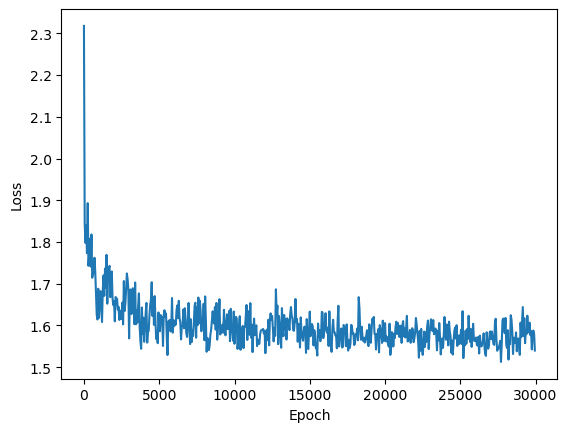

In [130]:
#loss_history, accuracy_history, epochs = network.get_histories()

plt.plot(range(0, int(network.epochs) * (network.num_batches), epochs), network.loss_history[::epochs])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

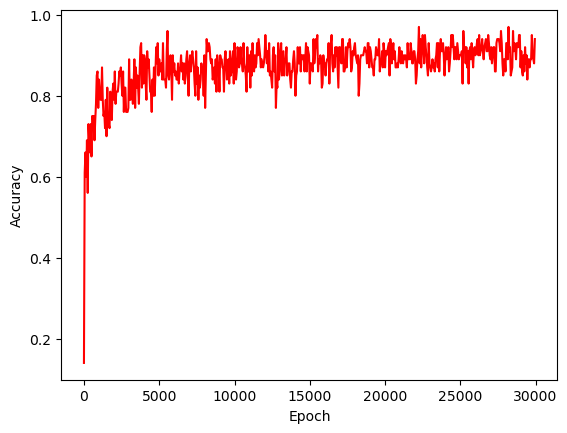

In [131]:
plt.plot(range(0, int(network.epochs) * (network.num_batches), epochs), network.accuracy_history[::epochs], color = "red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

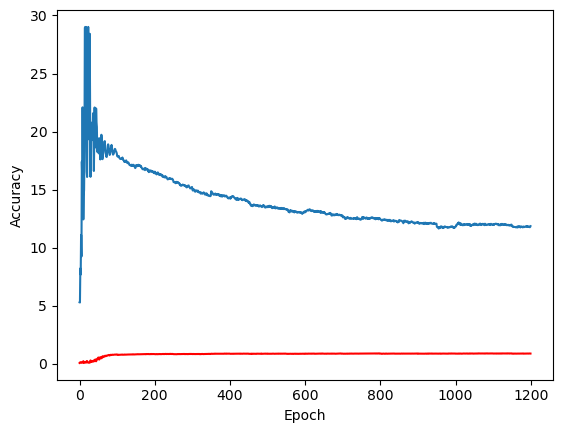

In [22]:
plt.plot(range(int(network.epochs) * 24), network.loss_history)
plt.plot(range(int(network.epochs) * 24), network.accuracy_history, color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [523]:
print(activation_layer3_forward)

[[1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 ...
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]
 [1.66666667e-06 1.66666667e-06 1.66666667e-06 ... 1.66666667e-06
  1.66666667e-06 1.66666667e-06]]


In [48]:
print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 12.739091058244902
Accuracy: 0.4186166666666667


## -----------------------------------------------------------------------------------------------------------------------------

In [235]:
dense_layer1_forward = dense_layer1.forward_pass(X_train)

#print(X_train.shape[1])
#print(dense_layer1_forward.shape)

activation_layer1_forward = activation_layer1.forward_pass(dense_layer1_forward)

dense_layer2_forward = dense_layer2.forward_pass(activation_layer1_forward)

activation_layer2_forward = activation_layer2.forward_pass(dense_layer2_forward)

dense_layer3_forward = dense_layer3.forward_pass(activation_layer2_forward)

activation_layer3_forward = activation_layer3.forward_pass(dense_layer3_forward)

#print(y_test.shape)

print(activation_layer3_forward)

loss = loss_function.calculate_mean_loss(activation_layer3_forward, y_train)

print("Loss:", loss)

[[1.67590275e-06 1.65152065e-06 1.65721082e-06 ... 1.65715403e-06
  1.67848615e-06 1.67018360e-06]
 [1.67588782e-06 1.65155903e-06 1.65721330e-06 ... 1.65719159e-06
  1.67850166e-06 1.67018850e-06]
 [1.67591281e-06 1.65160950e-06 1.65722753e-06 ... 1.65719984e-06
  1.67855277e-06 1.67021450e-06]
 ...
 [1.67591354e-06 1.65152998e-06 1.65723682e-06 ... 1.65715801e-06
  1.67850356e-06 1.67018524e-06]
 [1.67590307e-06 1.65158943e-06 1.65719749e-06 ... 1.65718721e-06
  1.67852821e-06 1.67022410e-06]
 [1.67589272e-06 1.65154629e-06 1.65720792e-06 ... 1.65716691e-06
  1.67847822e-06 1.67018461e-06]]
Loss: 13.304818431623891


In [236]:
predictions = np.argmax(activation_layer3_forward, axis = 1)

accuracy = np.mean(predictions == y_train)

print("Accuracy:", accuracy)

Accuracy: 0.10218333333333333


## -----------------------------------------------------------------------------------------------------------------------------

In [1]:
class NeuralNetwork:
    
    def __init__(self, no_of_in_nodes, no_of_out_nodes, no_of_hidden_nodes, learning_rate):
        self.no_of_in_nodes = no_of_in_nodes
        self.no_of_out_nodes = no_of_out_nodes
        self.no_of_hidden_nodes = no_of_hidden_nodes
        self.learning_rate = learning_rate 
        self.create_weight_matrices()
        
    
        

In [53]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

def relu(x):
    
    return np.maximum(0, x)

w1 = rng.random((image_size, hidden_layer_size))
w2 = rng.random((hidden_layer_size, output_layer_size))

print(w1.shape)

for i in range(epochs):
    
    loss = 0.0
    
    for j in range(len(X_train)):
        
        layer_0 = X_train[j]
        
        layer_1 = np.dot(layer_0, w1)
        layer_1 = relu(layer_1)
        
        layer_2 = np.dot(layer_1, w2)
    

(784, 100)
